In [170]:
from weaviate.classes.config import Configure, Property, DataType, Multi2VecField
from weaviate.classes.query import Rerank, MetadataQuery
from weaviate.classes.config import Reconfigure
from weaviate.util import generate_uuid5
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import weaviate
import pandas as pd
import base64
import weaviate.classes.query as wq


In [177]:
# Connect to the local Weaviate instance
client = weaviate.connect_to_local()

In [178]:
assert client.is_live() # Checks if the Weaviate server is live.

### ◻️ Preprocessing Data

In [30]:
# Load the dataset from a CSV file
women_df = pd.read_csv("data/women_shoes.csv", sep=",")
print(women_df.shape)
women_df.head(2)

(277, 8)


,name,description,price,currency,terms,image_downloads,extracted_footwear_type,iso_image
0,PEARL HEELED SLINGBACKS,Slingback heels with front pearl detail. Point...,79.9,USD,shoes,"['82aaf07d-4981-46d9-ab54-56d82c40cfa5', 'ea8b...",SLINGBACKS,ea8b9976-7cda-4e4c-9926-b357b1aa65c7
1,LEATHER BALLET FLATS,Mary Jane style leather ballet flats. Buckled ...,59.9,USD,shoes,"['3c5a4b1d-407b-4683-8489-795e1177aa4a', '769a...",BALLET FLATS,769a6f42-94a6-451b-9014-5fcf1100d212


In [57]:
data_wm = women_df.copy()

In [58]:
data_wm = data_wm[['description', 'currency', 'price', 'iso_image']]

In [59]:
def normalize_text_columns(df):
    for i, row in df.iterrows():
        df.loc[i, 'description'] = row['description'].lower()
        df.loc[i, 'currency'] = row['currency'].lower()
        df.loc[i, 'image_path'] = row['iso_image'] + ".jpg"
    return df

In [60]:
data_wm_normalized = normalize_text_columns(data_wm)
data_wm_normalized.head(2)

,description,currency,price,iso_image,image_path
0,slingback heels with front pearl detail. point...,usd,79.9,ea8b9976-7cda-4e4c-9926-b357b1aa65c7,ea8b9976-7cda-4e4c-9926-b357b1aa65c7.jpg
1,mary jane style leather ballet flats. buckled ...,usd,59.9,769a6f42-94a6-451b-9014-5fcf1100d212,769a6f42-94a6-451b-9014-5fcf1100d212.jpg


In [61]:
data_wm_normalized.drop(columns=['iso_image'], inplace=True)
data_wm_normalized.head(2)

,description,currency,price,image_path
0,slingback heels with front pearl detail. point...,usd,79.9,ea8b9976-7cda-4e4c-9926-b357b1aa65c7.jpg
1,mary jane style leather ballet flats. buckled ...,usd,59.9,769a6f42-94a6-451b-9014-5fcf1100d212.jpg


In [62]:
data_wm_normalized.shape

(277, 4)

### ◻️ Create `WomenShoesMM` Collection adding Generative Integration Capability
A generative integration in Weaviate refers to the ability to connect Weaviate with external generative AI models (such as LLMs) to enable retrieval augmented generation (RAG) functions. Weaviate offers different providers, such as OpenAI, Cohere, Anthropic, Mistral, NVIDIA, Anyscale, FriendliAI, xAI, OctoAI, AWS, and more, to configure a collection in Weaviate to use a generative module. Each collection can be set up with a generative module independently of its vectorizer module. 

⚠️ Important: 
* `.Vectorizer` (Deprecated):
In older versions of the Weaviate Python client (before v4.16.0), you would use Configure.Vectorizer to specify the vectorizer module for your collection. 
```bash
vectorizer_config=Configure.Vectorizer.text2vec_openai()
```

* `.Vectors` (Current):
Starting with Weaviate Python client v4.16.0, the API was updated to use Configure.Vectors instead. This new approach is more flexible and supports both single and multiple named vector.
```bash
vector_config=Configure.Vectors.multi2vec_clip(
    image_fields=[Multi2VecField(name="image")],
    text_fields=[Multi2VecField(name="description")]
)
```

⚠️ Important:  To apply changes to your docker-compose.yml (such as adding generative-ollama to ENABLE_MODULES), you need to restart your Weaviate container so it picks up the new environment variable.The standard way to do this is:

1. Stop the running containers
```bash
docker compose down
```
2. Start the containers again
```bash
docker compose up -d
```

This will recreate the Weaviate container with the updated configuration. You do not need to rebuild the image unless you have changed the Dockerfile itself; updating environment variables in docker-compose.yml and restarting is sufficient Modules configuration.

### ◻️ Add women shoes info to WomenShoesMM Collection

In [63]:
# Check if a collection named "Animals" exists on the Weaviate server. If the collection exists, delete it.
if(client.collections.exists("WomenShoesMM")):
    client.collections.delete("WomenShoesMM")

In [64]:

# Create a WomenShoesMM collection with multi-modal vectorization and generative AI capabilities
client.collections.create(
    name="WomenShoesMM",
    properties=[
        Property(name="description", data_type=DataType.TEXT),
        Property(name="price", data_type=DataType.NUMBER),
        Property(name="currency", data_type=DataType.TEXT),
        Property(name="image_path", data_type=DataType.TEXT),
        Property(name="image", data_type=DataType.BLOB),
    ],
    vector_config=Configure.Vectors.multi2vec_clip(
        image_fields=[Multi2VecField(name="image")],
        text_fields=[Multi2VecField(name="text")]
    ),
    generative_config=Configure.Generative.ollama(
        api_endpoint="http://host.docker.internal:11434",  # Adjust as needed for your setup
        model="gemma3:4b"  # Replace with your preferred Ollama model
    )
)

In [65]:
# Get the collection
women_shoes_mm = client.collections.use("WomenShoesMM")

In [66]:
data_wm_normalized.head()

,description,currency,price,image_path
0,slingback heels with front pearl detail. point...,usd,79.9,ea8b9976-7cda-4e4c-9926-b357b1aa65c7.jpg
1,mary jane style leather ballet flats. buckled ...,usd,59.9,769a6f42-94a6-451b-9014-5fcf1100d212.jpg
2,heeled slingbacks with faux patent leather fin...,usd,49.9,19b80e65-67a9-45f8-8139-e7b1da2ab448.jpg
3,heeled faux patent leather slingbacks. back st...,usd,49.9,deb51ea0-cb17-46ef-b381-77472db4f023.jpg
4,slingback block heel pumps. front strap with b...,usd,49.9,f60acf01-96a7-44cf-9245-ba3a2ef57920.jpg


In [68]:
# Enter context manager
with women_shoes_mm.batch.fixed_size(50) as batch: 
    # Loop through the data
    for i, row in tqdm(data_wm_normalized.iterrows()):
        # Convert image to base64
        img_dir = 'data/iso_women_shoes/'
        img_url = (img_dir + row['image_path'])
        with open(img_url, "rb") as file:
            image_b64 = base64.b64encode(file.read()).decode("utf-8") 

        # Build the object payload
        shoe_obj = {
            "description": row["description"],
            "price": row["price"],
            "currency": row["currency"],
            "image_path": img_url,
            "image": image_b64
        }

        # Add data to the batch
        batch.add_object(
            properties=shoe_obj,
            uuid=generate_uuid5(identifier=img_url)
        )# Batcher automatically sends batches

        
# Check for failed objects
if len(women_shoes_mm.batch.failed_objects) > 0:
    print(f"Failed to import {len(women_shoes_mm.batch.failed_objects)} objects")
    for failed in women_shoes_mm.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
        

277it [00:19, 14.49it/s] 


### ◻️ Retrieval Augmented Generation (RAG) 
Retrieval Augmented Generation (RAG) combines information retrieval with generative AI models.

In Weaviate, a RAG query consists of two parts: a search query, and a prompt for the model. Weaviate first performs the search, then passes both the search results and your prompt to a generative AI model before returning the generated response.

After configuring the generative AI integration, perform RAG operations, either with the `single prompt` or `grouped task` method.

`query`
- Purpose: Specifies the search criteria for retrieving objects from your Weaviate collection.
- How it works: The query is vectorized (by the model provider integration) and used to find the most relevant objects in the collection.


`single_prompt`
- Purpose: Generates a separate output for each object in the search results.
- How it works: You provide a prompt with placeholders (e.g., {title}) that are filled with properties from each object.
The generative model produces an output for each object individually.
- Result: Each object in the response includes its own generated output.

![single_prompt.png](https://docs.weaviate.io/assets/images/integration_ollama_rag_single-e404950fa7a2120110acf80c697ef6ff.png)


`grouped_task`
- Purpose: Generates a single output for the entire set of search results.
- How it works: You provide a prompt that considers the whole group of results.The generative model produces one output based on all the objects together.
- Result: The response contains one generated output for the group, plus the list of objects.

![grouped_task.png.png](https://docs.weaviate.io/assets/images/integration_ollama_rag_grouped-190b744e3fcbe9dfb0a4ac25ae3e0792.png)

🔗 Resource: [Ollama Generative AI with Weaviate](https://docs.weaviate.io/weaviate/model-providers/ollama/generative#retrieval-augmented-generation)

- ⚠️Use `obj.generated` (or o`bj.generative.text`) to get `single_prompt` results.
- ⚠️Use R`esponse.generative.text` to get `grouped_task` results.
- 👁️❌If you try to access `Response.generative.text` after providing only a `single_prompt`, it will return None, resulting in the error you saw.

In [125]:
# Verify the number of objects in the collection
response_0 = women_shoes_mm.aggregate.over_all(total_count=True)
print(response_0.total_count)

277


In [179]:
# Get the collection
women_shoes_mm = client.collections.use("WomenShoesMM")

## Get embeddings (vectors) as a list after indexing them in Weaviate

In [180]:
embbedings_list = []
for item in women_shoes_mm.iterator(include_vector=True):
    embbedings_list.append(item.vector)

In [ ]:
# Check the number of embeddings
len(embbedings_list)

277

In [ ]:
# Check the number of dimensions for each embedding
len(embbedings_list[0]['default'])

512

## Similarity Seach / Single prompt

In [202]:
# Perform query
response = women_shoes_mm.generate.near_text(
    query = "ankle boots",
    limit=5,
    single_prompt="Describe the following shoe in a single sentence: {description} and {price}{currency}.",
    return_metadata=MetadataQuery(distance=True)   
)

In [203]:
response.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('81979918-c1f1-5a82-88fc-763c2d87c3e6'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7120133638381958, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/09b72611-a7be-4022-97b4-4c0b86b977fb.jpg', 'currency': 'usd', 'description': 'leather ankle boots. lace-up closure. lug soles. rubberized rim. back pull tab. \n\nsole height: 1.6 inches (4 cm)', 'price': 129.0}, references=None, vector={}, collection='WomenShoesMM'),
 GenerativeObject(uuid=_WeaviateUUIDInt('2368c101-7d14-5bf9-a122-35968125efbf'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7121841907501221, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/a3ed8134-9183-456f-80c7-fa8645a77633.jpg', 'currency': 'usd', 'description': 'distressed effect leather an

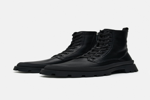

Generated output: These 129USD leather ankle boots feature a 1.6-inch (4cm) lug sole, lace-up closure, and a rubberized rim, complemented by a convenient back pull tab for easy on and off.
Distance: 0.7120133638381958


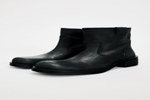

Generated output: These 129usd distressed effect leather ankle boots feature a squared toe, 1.6-inch (4 cm) heel, and convenient side pull tabs for a stylish and comfortable fit.
Distance: 0.7121841907501221


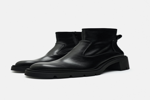

Generated output: These stylish heeled ankle boots feature a 2.4-inch heel, a durable lug sole, a comfortable stretch shaft, a rounded toe, a back pull tab, and a zip closure, all for $49.99.
Distance: 0.7132806777954102


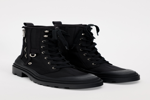

Generated output: These stylish fabric ankle boots feature a rounded toe, a 1.6-inch (4 cm) rubberized sole with a toe cap, laces and a side zipper, and a convenient back pull tab, all for $49.99.
Distance: 0.7133647203445435


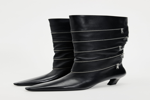

Generated output: These soft leather boots feature a wide shaft with zipper details, a pointed toe, and 2-inch kitten heels, all presented in a luxurious design for $199.
Distance: 0.7134901881217957


In [204]:
for obj in response.objects:
    display(Image.open(obj.properties["image_path"]).resize((150, 100)))
    #print(obj.properties["description"])
    #print(f"Generated output: {obj.generated}") obj.generated is deprecated
    print(f"Generated output: {obj.generative.text}")
    print(f"Distance: {obj.metadata.distance}")

## Similarity Search / more customized single prompt 

In [162]:
response_1 = women_shoes_mm.generate.near_text(
    query="ankle boots",
    limit=3,
    single_prompt=(
        "From the following description: {description}, "
        "extract and list: the type of footwear, the material, the color, the heel height in cm, "
        "and include the price ({price}{currency})."
    ),
    return_metadata=MetadataQuery(distance=True)  
    
    
)

In [163]:
response_1.objects

[GenerativeObject(uuid=_WeaviateUUIDInt('81979918-c1f1-5a82-88fc-763c2d87c3e6'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7120133638381958, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/09b72611-a7be-4022-97b4-4c0b86b977fb.jpg', 'currency': 'usd', 'description': 'leather ankle boots. lace-up closure. lug soles. rubberized rim. back pull tab. \n\nsole height: 1.6 inches (4 cm)', 'price': 129.0}, references=None, vector={}, collection='WomenShoesMM'),
 GenerativeObject(uuid=_WeaviateUUIDInt('2368c101-7d14-5bf9-a122-35968125efbf'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7121841907501221, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/a3ed8134-9183-456f-80c7-fa8645a77633.jpg', 'currency': 'usd', 'description': 'distressed effect leather an

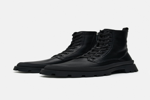

Here's the extracted information from the description:

*   **Type of footwear:** Ankle boots
*   **Material:** Leather
*   **Color:** (Not specified in the description)
*   **Heel height:** 4 cm (1.6 inches)
*   **Price:** 129 USD
Distance: 0.7120133638381958


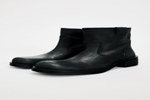

Here’s the breakdown of the footwear details from the description:

*   **Type of footwear:** Ankle boots
*   **Material:** Distressed effect leather
*   **Color:** (Not specified in the description, but implied to be a color associated with distressed leather – likely brown, black, or a combination)
*   **Heel height:** 4 cm (1.6 inches)
*   **Price:** 129 USD
Distance: 0.7121841907501221


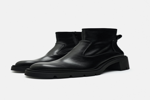

Here’s the extracted information from the description:

*   **Type of Footwear:** Heeled Ankle Boots
*   **Material:** (Not specified in the description - we can assume a typical boot material like leather or synthetic leather)
*   **Color:** (Not specified in the description)
*   **Heel Height:** 6 cm (2.4 inches)
*   **Price:** 49.9 USD
Distance: 0.7132806777954102


In [164]:
for obj in response_1.objects:
    display(Image.open(obj.properties["image_path"]).resize((150, 100)))
    print(obj.generative.text)
    print(f"Distance: {obj.metadata.distance}")

## Similarity Search / grouped task

In [165]:
response_2 = women_shoes_mm.generate.near_text(
    query="ankle boots",
    limit=3,
    grouped_task=(
        "For each shoe in the results, extract and list: the type of footwear, the material, the color, "
        "the heel height in cm, and the price from the properties {description},{price} and {currency}."
    ),
    return_metadata=MetadataQuery(distance=True)
)

In [166]:
print(response_2.objects)

[GenerativeObject(uuid=_WeaviateUUIDInt('81979918-c1f1-5a82-88fc-763c2d87c3e6'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7120133638381958, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/09b72611-a7be-4022-97b4-4c0b86b977fb.jpg', 'currency': 'usd', 'description': 'leather ankle boots. lace-up closure. lug soles. rubberized rim. back pull tab. \n\nsole height: 1.6 inches (4 cm)', 'price': 129.0}, references=None, vector={}, collection='WomenShoesMM'), GenerativeObject(uuid=_WeaviateUUIDInt('2368c101-7d14-5bf9-a122-35968125efbf'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=0.7121841907501221, certainty=None, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data/iso_women_shoes/a3ed8134-9183-456f-80c7-fa8645a77633.jpg', 'currency': 'usd', 'description': 'distressed effect leather ank

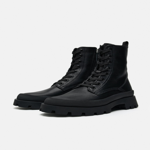

Distance: 0.7120133638381958


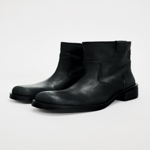

Distance: 0.7121841907501221


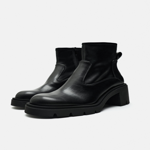

Distance: 0.7132806777954102
Here's the extracted information for each shoe:

**Shoe 1:**

*   **Type of Footwear:** Ankle Boots
*   **Material:** Leather
*   **Color:** (Not specified in the text)
*   **Heel Height:** 4 cm (1.6 inches)
*   **Price:** $129

**Shoe 2:**

*   **Type of Footwear:** Ankle Boots
*   **Material:** Leather
*   **Color:** (Not specified in the text)
*   **Heel Height:** 4 cm (1.6 inches)
*   **Price:** $129

**Shoe 3:**

*   **Type of Footwear:** Ankle Boots
*   **Material:** (Not specified in the text)
*   **Color:** (Not specified in the text)
*   **Heel Height:** 6 cm (2.4 inches)
*   **Price:** $49.90


In [167]:
for obj in response_2.objects:
    display(Image.open(obj.properties["image_path"]).resize((150, 150)))
    print(f"Distance: {obj.metadata.distance}")
print(response_2.generative.text)


## Similarity Search / Single Prompt / Rerank

To order search results from highest to lowest relevance using reranking in Weaviate, you must set up a reranking model for your collection and include the reranking parameter in your query. Reranking will reorder the initial search results using a more complex model, such as Cohere, Hugging Face, NVIDIA, Jina AI, or Voyage AI reranking. This will return the results sorted by the reranker's relevance score, from most relevant to least relevant. The rerank_score value is provided by the reranker model and reflects the relevance of each result to your query. The distance value is the original vector search distance.

- ⚠️ You must have a reranker model configured for your collection.
- ⚠️ The reranker works as a second step, reordering the top N results of your initial search.
- ⚠️ You can use reranking with `vector`, `BM25`, or `hybrid` **searches**.

## Rerank Configuration
### Docker Option 2: Add the configuration manually

```bash
services:
  weaviate:
    # Other Weaviate configuration
    environment:
      RERANKER_INFERENCE_API: http://reranker-transformers:8080  # Set the inference API endpoint
  reranker-transformers:  # Set the name of the inference container
    image: cr.weaviate.io/semitechnologies/reranker-transformers:cross-encoder-ms-marco-MiniLM-L-6-v2
    environment:
      ENABLE_CUDA: 0  # Set to 1 to enable
```

```bash
docker compose up -d
```

Available Models from Hugging Face Transformers library.
These pre-trained models are open-sourced on Hugging Face.
- `cross-encoder/ms-marco-MiniLM-L-6-v2`
- `cross-encoder/ms-marco-MiniLM-L-2-v2`
- `cross-encoder/ms-marco-TinyBERT-L-2-v2`

🔗 [Locally Hosted Transformers Reranker Models with Weaviate](https://docs.weaviate.io/weaviate/model-providers/transformers/reranker)